In [1]:
from process_bigraph import Composite 

from biosimulators_processes import CORE 

Cannot register DynamicFBA. Error:
**
name 'Process' is not defined
**
Cannot register SimulariumSmoldynStep. Error:
**
No module named 'simulariumio'
**
Cannot register MongoDatabaseEmitter. Error:
**
No module named 'simulariumio'
**


In [4]:
CORE.process_registry.registry

{'console-emitter': process_bigraph.composite.ConsoleEmitter,
 'ram-emitter': process_bigraph.composite.RAMEmitter,
 'composite': process_bigraph.composite.Composite,
 'copasi-process': biosimulators_processes.processes.copasi_process.CopasiProcess,
 'tellurium-process': biosimulators_processes.processes.tellurium_process.TelluriumProcess,
 'utc-amici': biosimulators_processes.processes.amici_process.UtcAmici,
 'utc-copasi': biosimulators_processes.processes.copasi_process.UtcCopasi,
 'utc-tellurium': biosimulators_processes.processes.tellurium_process.UtcTellurium,
 'smoldyn-process': biosimulators_processes.processes.smoldyn_process.SmoldynProcess,
 'smoldyn-io-process': biosimulators_processes.processes.smoldyn_process.SmoldynIOProcess,
 'copasi-step': biosimulators_processes.steps.ode_simulation.CopasiStep,
 'tellurium-step': biosimulators_processes.steps.ode_simulation.TelluriumStep,
 'amici-step': biosimulators_processes.steps.ode_simulation.AmiciStep,
 'plotter': biosimulators_p

In [2]:
model_fp = '/Users/alexanderpatrie/Desktop/repos/biosimulator-processes/test_suite/examples/sbml-core/Elowitz-Nature-2000-Repressilator/BIOMD0000000012_url.xml'

doc = {
    'dFBA': {
        '_type': 'process',
        'address': 'local:dfba-process',
        'config': {
            'model': {
                'model_source': model_fp
            },
            'simulator': 'copasi',
            'start': 0,
            'stop': 10,
            'steps': 100
        },
        'inputs': {},
        'outputs': {
            'solution': ['solution_store']
        }
    },
    'emitter': {
        '_type': 'step',
        'address': 'local:ram-emitter',
        'config': {
            'emit': {
                'solution': 'tree[float]'
            }
        },
        'inputs': {
            'solution': ['solution_store']
        }
    }
}


spec = doc.copy()

In [3]:
from cobra.io import read_sbml_model


model = read_sbml_model(model_fp)

model

Model does not contain SBML fbc package information.
SBML package 'layout' not supported by cobrapy, information is not parsed
SBML package 'render' not supported by cobrapy, information is not parsed
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction Reaction1 "degradation of LacI transcripts">'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction Reaction1 "degradation of LacI transcripts">'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction Reaction2 "degradation of TetR transcripts">'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction Reaction2 "degradation of TetR transcripts">'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction Reaction3 "degradation of CI transcripts">'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction Reaction3 "degradation of CI transcripts">'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction Reaction4 "translation of LacI">'
Missing upper flux bound se

Name,BIOMD0000000012
Memory address,103d2ada0
Number of metabolites,6
Number of reactions,12
Number of genes,0
Number of groups,0
Objective expression,0
Compartments,cell


In [3]:
comp = Composite(
    config={'state': spec},
    core=CORE
)

Exception: process "dfba-process" not found

In [8]:
comp.run(3)

KeyboardInterrupt: 

In [5]:
import os 
from pathlib import Path

from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import cobra
from cobra.io import load_model as load_cobra, read_sbml_model
from basico import * 
import numpy as np
from tqdm import tqdm

from biosimulators_processes.helpers import generate_reaction_mappings


# set up models
model_file = '/Users/alexanderpatrie/Desktop/repos/biosimulator-processes/test_suite/examples/sbml-core/Elowitz-Nature-2000-Repressilator/BIOMD0000000012_url.xml'
# model_file = '/Users/alexanderpatrie/Desktop/repos/biosimulator-processes/test_suite/examples/sbml-core/Caravagna-J-Theor-Biol-2010-tumor-suppressive-oscillations/Caravagna2010.xml'

# set up cobra model
data_dir = Path(os.path.dirname(model_file))
path = data_dir / model_file.split('/')[-1]
cobrapy = read_sbml_model(str(path.resolve())) 
# cobrapy = load_cobra('textbook')

# set up copasi model
copasi = load_model(model_file)

# global store TODO: use this as update statelet process bigraph handle this
input_state = {}
concentrations = {}


def add_dynamic_bounds(fba_model, utc_model, y, mappings):
    """
    # 1. get reaction mappings 
    # 2. y = get_species(model=copasi).initial_concentration.values
    # 3. for each species in y, calculate max import (TODO: make this specific)
    # 4. for each species mapping, use the dict val (reaction name) to say fba_model.reactions.get_by_id(reaction_name) = max_import
    """
    # Zip species names and their corresponding concentrations for iteration
    species_concentrations = y  # dict(zip(species_names, y))
    for mapping in mappings:
        for species, reaction_name in mapping.items():  # Each mapping is a dictionary like {'LacI mRNA': 'degradation of LacI transcripts'}
            if species in species_concentrations:
                concentration = species_concentrations[species]
                rxn_id = reaction_name.replace(" ", "_")
                for reaction in fba_model.reactions:
                    # TODO: make this more specific
                    if "degradation" in reaction_name:
                        max_import = -10 * concentration / (5 + concentration)
                        fba_model.reactions.get_by_id(reaction.id).lower_bound = max_import
                    elif "transcription" in reaction_name:
                        max_import = 5 * concentration / (3 + concentration)
                        fba_model.reactions.get_by_id(reaction.id).lower_bound = max_import
                    elif "translation" in reaction_name:
                        max_import = 8 * concentration / (4 + concentration)
                        fba_model.reactions.get_by_id(reaction.id).lower_bound = max_import


def apply_mm_kinetics(concentration, Vmax, Km):
    """Apply Michaelis-Menten kinetics to calculate the flux."""
    return (Vmax * concentration) / (Km + concentration)


n_dynamic_system_calls = 0

def dynamic_system(t, y, fba_model, utc_model, mappings):
    # The issue with less time point data vs appropriate scale specified will be solvved with pbg if we simply connect to the copasi process output ports as inputs 
    # reference global store TODO: this will be state arg within the Pbg update method
    global n_dynamic_system_calls
    n_dynamic_system_calls += 1
    
    global input_state 

    # calc duration TODO: again this will be done by pbg
    t_prev = input_state['time'][-1]

    # run copasi for teh given dur
    run_time_course(t_prev, t, 1, model=utc_model, update_model=True, use_numbers=True)
    # output_names = get_species(model=copasi).index.tolist()
    # run_time_course_with_output(output_selection=output_names, intervals=1, model=copasi, update_model=True, use_numbers=True)
    # track times TODO: this will be done by pbg as output AND input ports
    input_state['time'].append(t)
    # set y to this value array
    y = get_species(model=utc_model)['concentration'].to_dict()
    # update global store TODO: do this with process bigraph
    for name, value in y.items():
        input_state['floating_species_concentrations'][name].append(value)
        concentrations[name].append(value)

    # update the FBA model's reaction bounds using species concentrations and mappings
    add_dynamic_bounds(fba_model, utc_model, y, mappings)

    # Run FBA with updated bounds and calculate fluxes, first clearing constraints
    # cobra.util.add_lp_feasibility(fba_model)
    fba_model = add_lp_feasibility_with_check(fba_model)
    feasibility = cobra.util.fix_objective_as_constraint(fba_model)
    
    # Example of reactions to optimize (can vary based on your specific model)
    reaction_list = [rxn.id for rxn in fba_model.reactions]
    obj_directions = ['max' for _ in reaction_list]  # TODO: make this more fine-grained
    lex_constraints = cobra.util.add_lexicographic_constraints(fba_model, reaction_list, obj_directions)

    # scale fluxes by the concentration for each species at time t: either for biomass or by mm kinetics
    fluxes = []
    for species, concentration in y.items():
        if species in concentrations.keys():
            # handle scaling by biomass
            if species == 'biomass':
                biomass_concentration = y['biomass']
                flux = lex_constraints.values * biomass_concentration
                fluxes.append(flux)
            else:
                # handle scaling by mm kinetics TODO: change this to be dynamic input
                Vmax, Km = 10, 5
                flux = apply_mm_kinetics(concentration, Vmax, Km)
                fluxes.append(flux)
        else:
            # give raw values if not TODO: handle this differently
            fluxes.append(lex_constraints.values)

    # update progress bar
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description(f't = {t:.3f}')

    return fluxes


dynamic_system.pbar = None


def infeasible_event(t, y, fba_model, utc_model, mappings):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """
    with fba_model:
        add_dynamic_bounds(fba_model, utc_model, y, mappings)
        # cobra.util.add_lp_feasibility(fba_model)
        updated_model = add_lp_feasibility_with_check(fba_model)
        feasibility = cobra.util.fix_objective_as_constraint(updated_model)
        # feasibility = fba_model.optimize().objective_value 

    val = feasibility - infeasible_event.epsilon
    return val


def add_lp_feasibility_with_check(fba_model):
    """Add LP feasibility constraints with a check for existing constraints."""
    prob = fba_model.problem  # Access the solver

    for met in fba_model.metabolites:
        # Check if the feasibility variables already exist and remove them
        s_plus_name = "s_plus_" + met.id
        s_minus_name = "s_minus_" + met.id
        
        if s_plus_name in fba_model.variables:
            fba_model.remove_cons_vars(fba_model.variables[s_plus_name])
        if s_minus_name in fba_model.variables:
            fba_model.remove_cons_vars(fba_model.variables[s_minus_name])
        
        # Now add the new variables
        s_plus = prob.Variable(s_plus_name, lb=0)
        s_minus = prob.Variable(s_minus_name, lb=0)
        
        fba_model.add_cons_vars([s_plus, s_minus])

        # Add constraint if missing
        if met.id not in fba_model.constraints:
            fba_model.constraints[met.id] = prob.Constraint(0, name=met.id)
        
        # Set the linear coefficients
        fba_model.constraints[met.id].set_linear_coefficients({s_plus: 1.0, s_minus: -1.0})

    return fba_model


# 1. run get_species(model=copasi).initial_concentration.to_dict().
# 2. assign 1 to y0
# 3. gen reaction mapping
# 4. specify num steps
# 5. add 3 and 4 to args below


def run_dfba():
    # time params TODO: make these config params
    start = 400
    stop = 1000
    steps = 600
    ts = np.linspace(start, stop, steps + 1)

    # initial state
    global concentrations
    global input_state 
    initial_concentrations = get_species(model=copasi)['initial_concentration'].to_dict()
    concentrations = {name: [initial_concentrations[name]] for name in initial_concentrations.keys()}
    input_state = {
        'floating_species_concentrations': {name: [initial_concentrations[name]] for name in initial_concentrations.keys()},
        'time': [start],
    }
    y0 = list(initial_concentrations.values())
    mappings = generate_reaction_mappings(list(initial_concentrations.keys()), cobrapy)
    # add_dynamic_bounds(cobrapy, copasi, initial_concentrations, mappings)

    # solver params
    method = 'BDF'  # 'BDF', 'RK45'
    rTol = 1e-5
    aTol = 1e-7
    infeasible_epsilon = 1e-6
    infeasible_direction = 1 

    # set infeasibility params TODO: make this config params
    infeasible_event.epsilon = infeasible_epsilon
    infeasible_event.direction = infeasible_direction
    infeasible_event.terminal = True
    # run and get solution
    with tqdm() as pbar:
        dynamic_system.pbar = pbar

        sol = solve_ivp(
            fun=dynamic_system,
            events=[infeasible_event],
            t_span=(ts.min(), ts.max()),
            y0=y0,
            t_eval=ts,
            rtol=rTol,
            atol=aTol,
            method=method,
            args=(cobrapy, copasi, mappings)
        )
    state = input_state.copy()
    state.update({'fluxes': sol.y.tolist()})
    # remove extra timepoints TODO: pbg will take care of this 
    for key, val in state.items():
        if isinstance(val, list):
            if key == "time":
                state[key] = sol.t.tolist()
        else:
            for name, datum in val.items():
                state[key][name] = list(set(datum))
    return state, sol


results, sol = run_dfba()

Model does not contain SBML fbc package information.
SBML package 'layout' not supported by cobrapy, information is not parsed
SBML package 'render' not supported by cobrapy, information is not parsed
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction Reaction1 "degradation of LacI transcripts">'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction Reaction1 "degradation of LacI transcripts">'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction Reaction2 "degradation of TetR transcripts">'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction Reaction2 "degradation of TetR transcripts">'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction Reaction3 "degradation of CI transcripts">'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction Reaction3 "degradation of CI transcripts">'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction Reaction4 "translation of LacI">'
Missing upper flux bound se

In [8]:
sol = cobrapy.optimize()
sol

,fluxes,reduced_costs
Reaction1,1000.0,0.0
Reaction2,1000.0,0.0
Reaction3,1000.0,2.0
Reaction4,1000.0,0.0
Reaction5,1000.0,0.0
...,...,...
Reaction8,1000.0,0.0
Reaction9,1000.0,0.0
Reaction10,1000.0,0.0
Reaction11,1000.0,0.0


In [4]:
results


{'floating_species_concentrations': {'LacI protein': [0.0,
   2052.222173066479,
   2075.280505016768,
   2081.0216096433423,
   2094.3966603174686,
   50.26248379493644,
   50.5343324288743,
   50.97340308752594,
   50.227494429653454,
   52.452334303585616,
   50.06534728545987,
   54.750666582750995,
   55.055935248855484,
   57.603309488220546,
   57.95741096458364,
   53.01157963429096,
   60.65019034139923,
   53.62436239240017,
   62.1948845118612,
   62.16510702790778,
   65.94241378258225,
   58.89051653514467,
   67.60902605510263,
   60.20526598242106,
   67.55512783768737,
   70.43688220517653,
   70.24058127269726,
   72.29527629730242,
   73.38602050798286,
   74.37306791462251,
   75.07981627099811,
   74.66357372601567,
   77.86148101289099,
   77.39761740971521,
   72.40574728842486,
   80.48647406145308,
   79.40290437743819,
   2130.859202737975,
   83.0785858996185,
   82.70894968384857,
   82.94156781170396,
   86.49656324713598,
   86.93887814923089,
   83.0774862

In [5]:
import pandas as pd 

pd.DataFrame(results['floating_species_concentrations'])

,LacI protein,TetR protein,cI protein,LacI mRNA,TetR mRNA,cI mRNA
0,0.000000,0.000000,0.000000,0.000000,0.824705,0.000000
1,0.018856,0.347216,0.172765,0.470401,1.629741,1.211422
2,1.030086,2.198174,0.328763,1.219797,2.662608,1.324711
3,1.485616,2.832178,2.217119,1.682586,3.472136,1.549265
4,3.584781,4.109175,3.343922,4.122035,4.621470,1.660447
...,...,...,...,...,...,...
624,2003.756461,2018.335076,2002.578958,4.984707,1.001471,0.735871
625,2027.423339,2026.927218,2011.844815,1.931617,0.371101,0.737193
626,2028.379834,2039.331367,2020.136765,5.764340,0.822690,7.539054
627,2030.314435,2041.872949,0.000004,0.121340,0.331543,7.445147


In [8]:
tc = run_time_course(duration=400.00232 - 400, model=copasi)

In [9]:
tc

,LacI protein,TetR protein,cI protein,LacI mRNA,TetR mRNA,cI mRNA,Values[beta],Values[alpha0],Values[alpha],Values[average mRNA life time],Values[kd_mRNA],Values[kd_prot],Values[k_tl],Values[a_tr],Values[a0_tr]
Time,,,,,,,,,,,,,,,
0.00000,1942.192983,418.279067,51.245413,32.673849,0.148413,0.653356,0.2,0.216404,216.187852,2.88539,0.346574,0.069315,6.931472,29.97,0.03
0.00232,1942.406071,418.214195,51.247680,32.673971,0.148393,0.653530,0.2,0.216404,216.187852,2.88539,0.346574,0.069315,6.931472,29.97,0.03


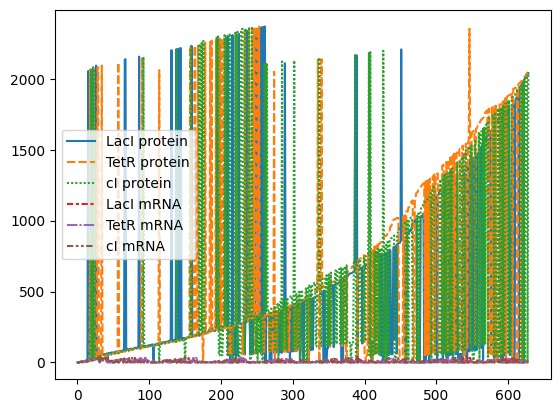

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns 

data = results['floating_species_concentrations']
sns.lineplot(data=pd.DataFrame(results['floating_species_concentrations']))
# for name, vals in data.items():
#     sns.lineplot(x=ts, y=vals, label=name)

plt.show()

In [1]:
import numpy as np 

T = np.linspace(400, 1000, 600)

T[1] - T[0], T[2] - T[1]

(1.0016694490818168, 1.0016694490818168)

In [ ]:
mod = load_model(model_file) 
for _ in range(10):
    run_time_course(model=mod, update_model=True, intervals=1)

spec = get_species(model=mod)['concentration'].to_dict()

In [3]:
get_species(model=copasi).index.tolist()

['LacI protein',
 'TetR protein',
 'cI protein',
 'LacI mRNA',
 'TetR mRNA',
 'cI mRNA']

In [ ]:
m = load_model(model_file)

tc = run_time_course(400, 1000, 600, model=m, update_model=True)

<Axes: xlabel='Time'>

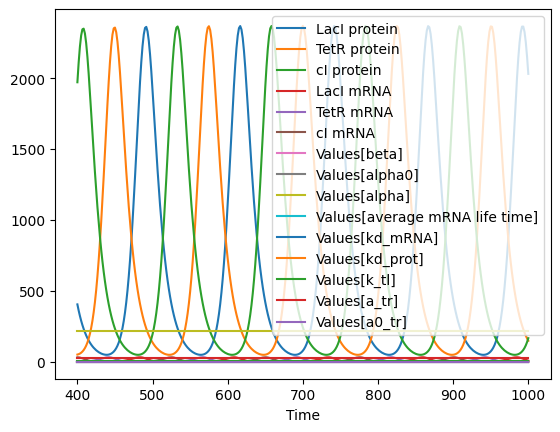

In [ ]:
tc.plot()

In [2]:
from basico import * 

m = load_model('/Users/alexanderpatrie/Desktop/repos/biosimulator-processes/test_suite/examples/sbml-core/Caravagna-J-Theor-Biol-2010-tumor-suppressive-oscillations/Caravagna2010.xml')

In [3]:
get_species(model=m)

,compartment,type,unit,initial_concentration,initial_particle_number,initial_expression,expression,concentration,particle_number,rate,particle_number_rate,key,sbml_id,transition_time,display_name
name,,,,,,,,,,,,,,,
T,compartment,reactions,mmol/ml,1.0,6.022141e+20,,,1.0,6.022141e+20,0.179997,1.083967e+20,Metabolite_3,T,5.555556,T
E,compartment,reactions,mmol/ml,1.0,6.022141e+20,,,1.0,6.022141e+20,-0.010000,-6.022137e+18,Metabolite_4,E,33.333333,E
I,compartment,reactions,mmol/ml,1.0,6.022141e+20,,,1.0,6.022141e+20,-9.999512,-6.021847e+21,Metabolite_5,I,0.100000,I
